In [53]:
# Import packages
import torch
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from PIL import Image

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif torch.has_mps:
    device = 'mps'

## Part 1: (5 pts)
Load the CIFAR10 dataset and display one image of each class. Set up your dataloader using torchvision.transforms. Take into account the required preprocessing transformations expected by the model (ResNet18). Additionally include a data augmentation strategy and report it.

In [42]:
# Fix certificate errors
import requests
requests.packages.urllib3.disable_warnings()
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
# Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

In [66]:
# Download the dataset and display classes
transform_flip = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

trainset = torchvision.datasets.CIFAR10(root="../data", train=True, download=False, transform=transform_flip)
classes = trainset.class_to_idx
print(classes)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [67]:
# Print the dataset shape
trainset.data.shape

(50000, 32, 32, 3)

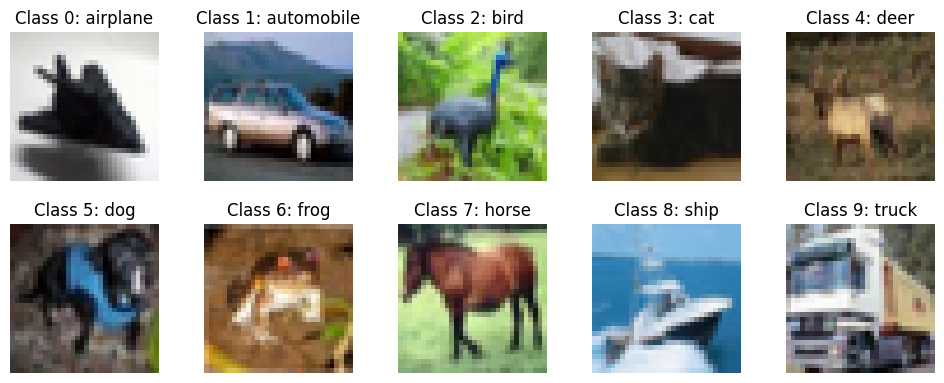

In [68]:
# Get the index of one image from each class
class_names = []
for c in classes:
    class_names.append(c)
indices = [-1 for i in range(10)]
for i, (image, label) in enumerate(trainset):
    if indices[label] < 0:
        indices[label] = i

# Display one image from each class
fig, axs = plt.subplots(2, 5, figsize=(10,4))
fig.tight_layout(h_pad=1, w_pad=0)
for i, index in enumerate(indices):
    if i <= 4:
        row = 0
        col = i
    else:
        row = 1
        col = i - 5
    axs[row,col].imshow(trainset.data[index])
    axs[row,col].set_title(f"Class {trainset.targets[index]}: {class_names[i]}")
    axs[row,col].axis('off')

In [69]:
# Set up the dataloader
batch_size = 128
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)

## Part 2: (5 pts)
Download an image of any of the classes present in the ImageNet dataset and make sure the pretrained model is able to classify it correctly. Then, try a transformation or noise injection that can trick the network.

In [97]:
# import the pretrained model and send it to device
model = torchvision.models.resnet18(pretrained=True)
model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [71]:
# get the ImageNet labels
with open('../data/imagenet_classes.txt') as f:
    imagenet_labels = [line.strip() for line in f.readlines()]
imagenet_labels

['0, tench',
 '1, goldfish',
 '2, great_white_shark',
 '3, tiger_shark',
 '4, hammerhead',
 '5, electric_ray',
 '6, stingray',
 '7, cock',
 '8, hen',
 '9, ostrich',
 '10, brambling',
 '11, goldfinch',
 '12, house_finch',
 '13, junco',
 '14, indigo_bunting',
 '15, robin',
 '16, bulbul',
 '17, jay',
 '18, magpie',
 '19, chickadee',
 '20, water_ouzel',
 '21, kite',
 '22, bald_eagle',
 '23, vulture',
 '24, great_grey_owl',
 '25, European_fire_salamander',
 '26, common_newt',
 '27, eft',
 '28, spotted_salamander',
 '29, axolotl',
 '30, bullfrog',
 '31, tree_frog',
 '32, tailed_frog',
 '33, loggerhead',
 '34, leatherback_turtle',
 '35, mud_turtle',
 '36, terrapin',
 '37, box_turtle',
 '38, banded_gecko',
 '39, common_iguana',
 '40, American_chameleon',
 '41, whiptail',
 '42, agama',
 '43, frilled_lizard',
 '44, alligator_lizard',
 '45, Gila_monster',
 '46, green_lizard',
 '47, African_chameleon',
 '48, Komodo_dragon',
 '49, African_crocodile',
 '50, American_alligator',
 '51, triceratops',
 

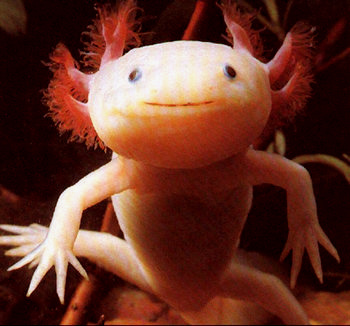

In [72]:
# open the image from ImageNet
axolotl = Image.open("../data/axolotl.JPEG")
axolotl

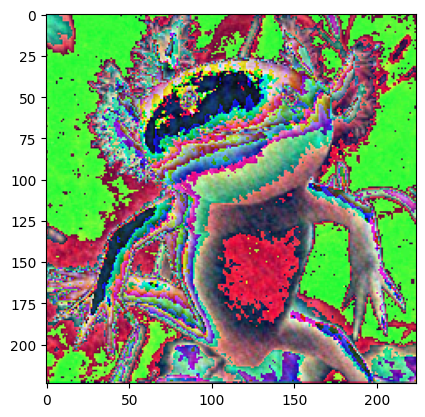

In [73]:
# preprocess the axolotl image from ImageNet
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
axolotlT = preprocess(axolotl)
plt.imshow(transforms.ToPILImage()(axolotlT))

In [79]:
# use the model to predict for the image
model.eval()
outputA = model(axolotlT.unsqueeze(0).to(device))
probs = torch.nn.Softmax(dim=1)(outputA)
probs.shape

torch.Size([1, 1000])

'29, axolotl'

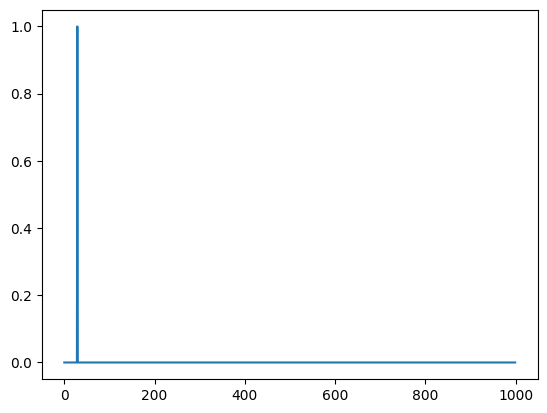

In [80]:
# plot the guess of the model for the image
plt.plot(probs.detach().cpu()[0])
imagenet_labels[probs.argmax()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


'489, chainlink_fence'

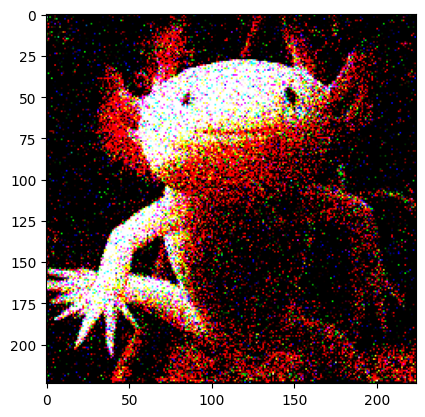

In [96]:
# noise injection to trick the model
noise = np.random.normal(0, 1, axolotlT.unsqueeze(0).size())
noisy = axolotlT.unsqueeze(0) + torch.tensor(noise, dtype=torch.float32)
with torch.no_grad():
    output = model(noisy.to(device))
probs = torch.nn.Softmax(dim=1)(output)
plt.imshow(noisy.squeeze(0).permute(1, 2, 0).numpy())
imagenet_labels[probs.argmax()]

## Part 3: (5 pts)
Now we will retrain the model for CIFAR10. Freeze all of the layers except for the last fully connected layer. Allow this last layer to adapt to the CIFAR10 dataset during the training. Create a validation set and implement an early stopping strategy. Plot the validation accuracy vs epochs and report your selection of hyper-parameters.

In [62]:
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

trainset = torchvision.datasets.CIFAR10(root="../data", train=True, download=False, transform=preprocess)
trainloader = DataLoader(trainset, batch_size=128)

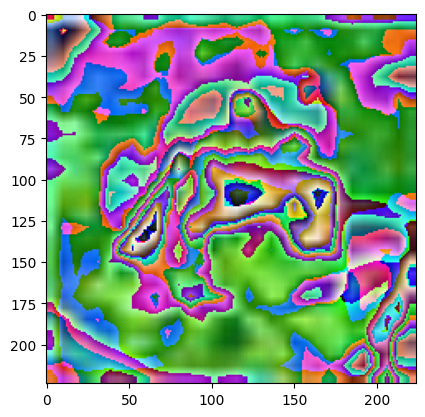

In [63]:
images, labels = next(iter(trainloader))
plt.imshow(transforms.ToPILImage()(images[0]))

In [64]:
output1layer = model.conv1(images[0].unsqueeze(0))
output1layer.shape

torch.Size([1, 64, 112, 112])

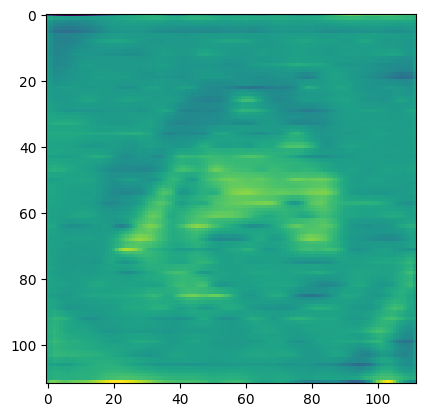

In [65]:
plt.imshow(output1layer[0, 10].detach())

## Part 4: (5 pts)
Finally, retrain the network in a similar way as in the previous part. In this case, unfreeze the first convolutional layer and the first convolutional layer present in the first "BasicBlock", in addition to the final fully connected layer. Plot and compare the filters of the first convolutional layer for the original model with the new filters learned after you retrain it. Again, use early stopping on your validation set and plot the validation accuracy vs epochs. Report how you selected your hyperparameters.